# WARNING: review PREDICT function format -- next_state ???
# from REINFORCE algo. act() is returning on "pred action" --- *** NO **** next state 

## Milling Tool Wear Maintenance Policy using the REINFORCE algorithm

- Ver. 4.1: 01-May-2023 - Improved plots
- Ver. 4.5: 01-May-2023 - Add Stable-Baselines algo.
- Ver. 4.6: 02-May-2023 - Expt RF vs SB-3 PPO, scaled rewards: 1/10^6 

In [1]:
import numpy as np
import pandas as pd

import milling_tool_environment
import utilities
from milling_tool_environment import MillingTool_V2
from utilities import plot_learning_curve, single_axes_plot, two_axes_plot, two_variable_plot, plot_error_bounds, test_script, write_test_results
from reinforce_classes import PolicyNetwork, Agent

import datetime
dt = datetime.datetime.now()
dt_d = dt.strftime('%m-%b-%Y')
dt_t = dt.strftime('%H_%M_%S')

In [2]:
import importlib
importlib.reload(milling_tool_environment)
importlib.reload(utilities)

<module 'utilities' from 'D:\\Rajesh\\ResearchLab\\LG_\\utilities.py'>

In [3]:
# Milling operation constants
WEAR_THRESHOLD = 3.0 # mm
WEAR_THRESHOLD_NORMALIZED = 1.0 # normalized to the max wear threshold
MILLING_OPERATIONS_MAX = 400
ADD_NOISE = 0.0
BREAKDOWN_CHANCE = 0.0

# Stable-Baselines algo. to compare against
SB_ALGO = 'PPO'

# Policy network learning parameters
gamma = 0.99
alpha = 0.01
EPISODES = 300 # Train for N episodes
PREFIX = f'results_plots/Tool_Wear_{dt_d}_{dt_t}'
DATA_FILE = 'Tool_Wear_VB.csv'
RESULTS_FILE = 'results_plots/test_results.csv'

Tool wear data imported (121 records). WEAR_THRESHOLD_NORMALIZED: 0.168 




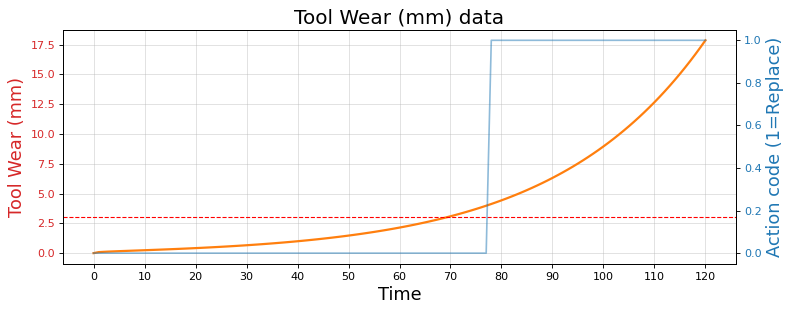

In [4]:
## Read data
df = pd.read_csv(DATA_FILE)
df = df[['time', 'VB_mm', 'ACTION_CODE']]

# Normalizing entire df with min-max scaling
WEAR_MIN = df['VB_mm'].min() 
WEAR_MAX = df['VB_mm'].max()
WEAR_THRESHOLD_NORMALIZED = (WEAR_THRESHOLD-WEAR_MIN)/(WEAR_MAX-WEAR_MIN)
df_normalized = (df-df.min())/(df.max()-df.min())
print(f'Tool wear data imported ({len(df.index)} records). WEAR_THRESHOLD_NORMALIZED: {WEAR_THRESHOLD_NORMALIZED:4.3f} \n\n')

## Visualize the data
n_records = len(df.index)
x = df['time'].values.tolist()
y1 = df['VB_mm'].values.tolist()
y2 = df['ACTION_CODE'].values.tolist()

two_axes_plot(x, y1, y2, title='Tool Wear (mm) data', x_label='Time', y1_label='Tool Wear (mm)', y2_label='Action code (1=Replace)', xticks=10,threshold=WEAR_THRESHOLD)

## REINFORCE RL Algorithm

In [5]:
### Main loop
rewards_history = []
loss_history = []

env = MillingTool_V2(df_normalized, WEAR_THRESHOLD_NORMALIZED, MILLING_OPERATIONS_MAX, ADD_NOISE, BREAKDOWN_CHANCE)

input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n

agent_RF = Agent(input_dim, output_dim, alpha, gamma)

for episode in range(EPISODES):
    state = env.reset()
    
    # Sample a trajectory
    for t in range(MILLING_OPERATIONS_MAX): # Max. milling operations desired
        action = agent_RF.act(state)
        state, reward, done, info = env.step(action)
        agent_RF.rewards.append(reward)
        #env.render()
        if done:
            # print('** DONE **', info)
            break
            
    # Learn during this episode 
    loss = agent_RF.learn() # train per episode
    total_reward = sum(agent_RF.rewards)
    
    # Record statistics for this episode
    rewards_history.append(total_reward)
    loss_history.append(loss.item()) # Extract values from list of torch items for plotting
    
    # On-policy - so discard all data 
    agent_RF.onpolicy_reset()

    if (episode%100 ==0):
        print(f'[{episode:04d}] Loss: {loss:>10.2e} | Reward: {total_reward:>10.2e} | Ep.length: {env.ep_length:04d}')

[0000] Loss:  -2.23e+02 | Reward:  -3.71e+00 | Ep.length: 0400
[0100] Loss:   1.18e+01 | Reward:   9.23e-01 | Ep.length: 0400
[0200] Loss:   1.35e+01 | Reward:   2.10e+00 | Ep.length: 0400


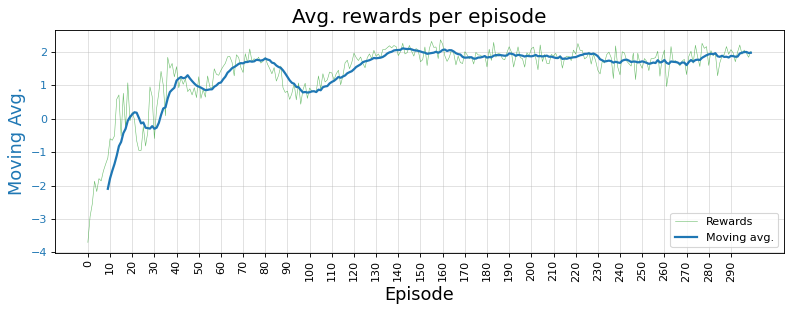

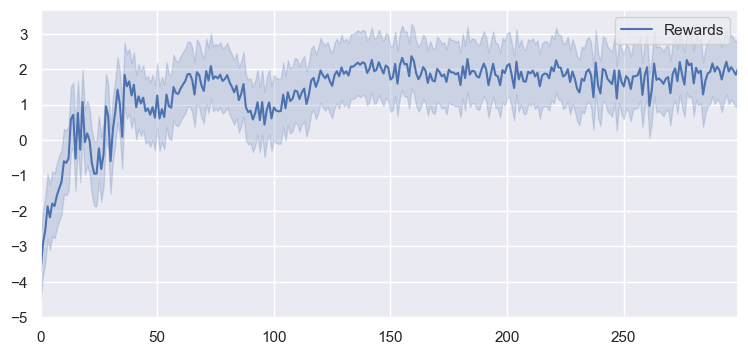

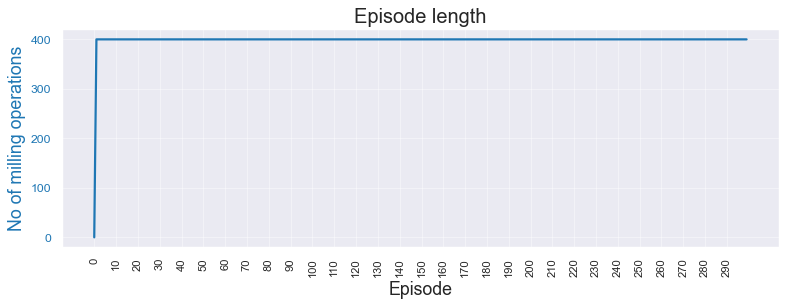

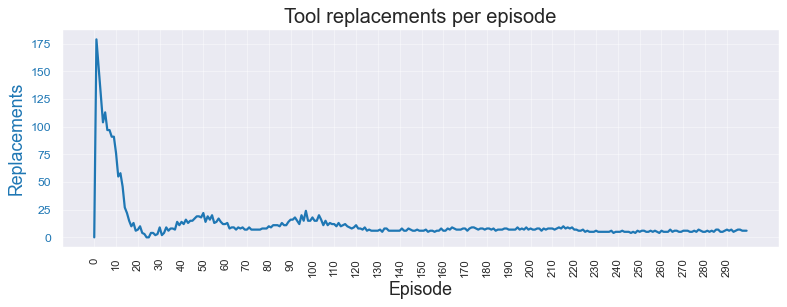

In [6]:
x = [i for i in range(EPISODES)]

## Moving average for rewards
ma_window_size = 10
# # Convert error array to pandas series
rewards = pd.Series(rewards_history)
windows = rewards.rolling(ma_window_size)
moving_avg = windows.mean()
moving_avg_lst = moving_avg.tolist()
y1 = rewards
y2 = moving_avg_lst

filename = PREFIX + '_Avg_episode_rewards.png'
two_variable_plot(x, y1, y2, 'Avg. rewards per episode', 'Episode', 'Avg. Rewards', 'Moving Avg.', 10, filename)

plot_error_bounds(x, y1)

filename = PREFIX + '_Episode_Length.png'
single_axes_plot(x, env.ep_length_history, 'Episode length', 'Episode', 'No of milling operations', 10, 0.0, filename)

filename = PREFIX + '_Tool_Replacements.png'
single_axes_plot(x, env.ep_tool_replaced_history, 'Tool replacements per episode', 'Episode', 'Replacements', 10, 0.0, filename)

# filename = PREFIX + '_Avg_episode_rewards.png'
# single_axes_plot(x, rewards_history, 'Avg. rewards per episode', 'Episode', 'Avg.Reward', 10, 0.0, filename)
# plot_learning_curve(x, rewards_history=rewards_history, loss_history=loss_history, moving_avg_n=10, filename=filename) 

In [7]:
# Create test cases
test_cases = np.random.randint(0, env.df_length-1, 100)
test_cases = np.sort(test_cases)

results = test_script(df_normalized, 'REINFORCE', EPISODES, env, agent_RF, test_cases, DATA_FILE, RESULTS_FILE)
write_test_results(results, RESULTS_FILE)

Algo.	Normal	Error	Replace	Error	Overall
	cases		cases		error
--------------------------------------------------
REINFORCE	65	0.031	35	0.371	0.150
--------------------------------------------------
- Test results written to file: results_plots/test_results.csv


## Stable-Baselines Algorithms

In [8]:
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C, PPO, DQN

In [26]:
algos = ['A2C','DQN','PPO']
for SB_ALGO in algos:
    print('{{SB_ALGO}: Training and Testing Stable-Baselines-3 {SB_ALGO} algorithm')
    if SB_ALGO.upper() == 'A2C': agent_SB = A2C('MlpPolicy', env, verbose=1)
    if SB_ALGO.upper() == 'DQN': agent_SB = DQN('MlpPolicy', env, verbose=1)
    if SB_ALGO.upper() == 'PPO': agent_SB = PPO('MlpPolicy', env, verbose=1)
    agent_SB.learn(total_timesteps=EPISODES)
    
    results = test_script(df_normalized, SB_ALGO, EPISODES, env, agent_SB, test_cases, DATA_FILE, RESULTS_FILE)
    write_test_results(results, RESULTS_FILE)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 401      |
|    ep_rew_mean     | -3.97    |
| time/              |          |
|    fps             | 516      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------


Algo.	Normal	Error	Replace	Error	Overall
	cases		cases		error
--------------------------------------------------
PPO	65	0.446	35	0.629	0.510
--------------------------------------------------
- Test results written to file: results_plots/test_results.csv
